# TA-13 — Analisis Sentimen Teks Menggunakan SVM (Sesuai Instruksi TA)
Notebook ini sudah dirapikan agar **sesuai instruksi TA**:
1) Load Data, 2) Preprocessing (Before vs After), 3) TF-IDF, 4) SVM Training & Prediction (Linear vs RBF), 5) Confusion Matrix + Analisis Error + WordCloud, 6) Tuning sederhana.

**Dataset:** `dataset_tiktok-comments-scraper_2025-12-25_12-58-44-970.csv`

> Catatan: Dataset TikTok tidak memiliki label sentimen. Untuk memenuhi TA (0=Negatif, 1=Positif), notebook ini membuat **label awal otomatis (weak labeling)** berbasis kamus kata. Sebaiknya lakukan koreksi label manual pada sebagian data untuk validitas lebih tinggi.

In [28]:
# (Opsional - jika di Google Colab) Install dependensi
# !pip -q install Sastrawi scikit-learn pandas matplotlib seaborn wordcloud

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from wordcloud import WordCloud

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory



## 1) Load Data

In [15]:
PATH_CSV = "dataset_tiktok-comments-scraper_2025-12-25_12-58-44-970.csv"
RAW_TEXT_COL = "text"  # kolom komentar asli pada dataset Anda

df = pd.read_csv(PATH_CSV)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

if RAW_TEXT_COL not in df.columns:
    raise ValueError(f"Kolom '{RAW_TEXT_COL}' tidak ditemukan. Ubah RAW_TEXT_COL sesuai dataset.")

Shape: (2820, 9)
Columns: ['text', 'diggCount', 'replyCommentTotal', 'createTimeISO', 'uniqueId', 'videoWebUrl', 'uid', 'cid', 'avatarThumbnail']


,text,diggCount,replyCommentTotal,createTimeISO,uniqueId,videoWebUrl,uid,cid,avatarThumbnail
0,"di buat transparan salah, gak di buat transpar...",30526,582,2025-12-24T11:04:54.000Z,fhrialfrizzy_,https://www.tiktok.com/@kumparan/video/7587345...,6947886291959890949,7587378781498016530,https://p16-common-sign.tiktokcdn-us.com/tos-a...
1,siapa dsni yg pilih Prabowo lanjut periode ke ...,16457,872,2025-12-24T12:24:29.000Z,candrawatilatif,https://www.tiktok.com/@kumparan/video/7587345...,6842017078591308802,7587399277259227911,https://p16-common-sign.tiktokcdn-us.com/tos-m...
2,Punya presiden segacor ini masih aja banyak yg...,20661,276,2025-12-24T11:03:59.000Z,pusaann9,https://www.tiktok.com/@kumparan/video/7587345...,7153983262540235803,7587377623371563794,https://p16-common-sign.tiktokcdn-us.com/tos-a...
3,"di usut salah GK di usut salah,ganti rakyat yg...",10372,192,2025-12-24T09:35:53.000Z,phememehandal,https://www.tiktok.com/@kumparan/video/7587345...,7041822420499792923,7587355814270206728,https://p16-common-sign.tiktokcdn-us.com/music...
4,cuma Pak Prabowo yg mampu melakukan ini semua ...,1268,26,2025-12-24T11:52:24.000Z,ria_1892,https://www.tiktok.com/@kumparan/video/7587345...,6602540778865049601,7587391015327253255,https://p19-common-sign.tiktokcdn-us.com/tos-a...


## 2) Persiapan Data & Preprocessing (Bobot 30%)
**Wajib:** case folding, filtering (hapus tanda baca/angka/emoji/karakter aneh), stopword removal.
**Opsional:** stemming (diaktifkan).

In [29]:
# Stopword + stemmer (Sastrawi)
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()

def basic_clean(text: str) -> str:
    text = str(text).lower()  # case folding
    text = re.sub(r"http\S+|www\.\S+", " ", text)  # hapus URL
    text = re.sub(r"[@#]\w+", " ", text)            # hapus mention/hashtag
    # buang emoji/karakter non-ascii (sederhana)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z\s]", " ", text)        # hapus angka/tanda baca/karakter aneh
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess(text: str) -> str:
    t = basic_clean(text)
    tokens = [w for w in t.split() if w not in stopwords]  # stopword removal
    t = " ".join(tokens)
    t = stemmer.stem(t)  # stemming (opsional, diaktifkan)
    return t

df[TEXT_COL] = df[RAW_TEXT_COL].fillna("").apply(preprocess)

# Wajib: tampilkan contoh Before vs After
print("=== Contoh Before vs After (5 baris) ===")
for i in range(min(5, len(df))):
    print("Before:", df.iloc[i][RAW_TEXT_COL])
    print("After :", df.iloc[i][TEXT_COL])
    print("-"*80)


=== Contoh Before vs After (5 baris) ===
Before: di buat transparan salah, gak di buat transparan lebih salah, mau apa masyarakat ini?
After : buat transparan salah gak buat transparan lebih salah mau apa masyarakat
--------------------------------------------------------------------------------
Before: siapa dsni yg pilih Prabowo lanjut periode ke duaa.
me🤗🤗🤗
After : siapa dsni yg pilih prabowo lanjut periode duaa me
--------------------------------------------------------------------------------
Before: Punya presiden segacor ini masih aja banyak yg gak bersyukur, bisanya cmn komen negatif dan menjatuhkan kayak nya bener deh mending ganti rakyat omon2
After : punya presiden segacor aja banyak yg gak syukur bisa cmn komen negatif jatuh kayak nya bener deh mending ganti rakyat omon
--------------------------------------------------------------------------------
Before: di usut salah GK di usut salah,ganti rakyat yg bener ini mah
After : usut salah gk usut salah ganti rakyat yg bener ma

## 3) Membuat Label Sentimen (0=Negatif, 1=Positif)
Karena dataset tidak berlabel, kita buat label awal otomatis (weak labeling). Data yang netral/ambigu akan dibuang agar menjadi klasifikasi biner.

In [32]:
TEXT_COL = "clean_text"
RAW_TEXT_COL = "text"   # pastikan ini sesuai dataset Anda

if TEXT_COL not in df.columns:
    raise ValueError(f"Kolom '{TEXT_COL}' belum ada. Jalankan preprocessing dulu untuk membuat df['{TEXT_COL}'].")

# LABEL_NUM = target utama TA (0=Negatif, 1=Positif)
LABEL_NUM_COL = "label_num"

# (Opsional untuk tampilan saja) LABEL_TEXT_COL
LABEL_TEXT_COL = "label_text"

positive_words = {
    "bagus","mantap","keren","hebat","senang","setuju","suka","baik","top","lucu",
    "puas","berhasil","terima","kasih","bangga","aman","percaya","solid","jelas","cakep",
    "oke","sip","jujur","makasih","mantul"
}
negative_words = {
    "buruk","jelek","parah","benci","marah","kesal","bohong","salah","gagal","rusak",
    "kecewa","jahat","ngawur","bodoh","payah","menyebalkan","tolol","ribet"
}

def weak_label(text_stem: str):
    toks = str(text_stem).split()
    pos = sum(t in positive_words for t in toks)
    neg = sum(t in negative_words for t in toks)

    if pos > neg:
        return 1
    elif neg > pos:
        return 0
    else:
        return None  # netral/ambigu -> lebih baik None daripada -1

# Buat label angka
df[LABEL_NUM_COL] = df[TEXT_COL].apply(weak_label)

# Buang yang netral/ambigu supaya jadi klasifikasi biner murni
df_lab = df.dropna(subset=[LABEL_NUM_COL]).copy()
df_lab[LABEL_NUM_COL] = df_lab[LABEL_NUM_COL].astype(int)

# Label teks hanya untuk laporan/visualisasi (opsional)
df_lab[LABEL_TEXT_COL] = df_lab[LABEL_NUM_COL].map({0: "Negatif", 1: "Positif"})

print("Distribusi label (setelah buang netral):")
print(df_lab[LABEL_NUM_COL].value_counts())
print("Total data berlabel:", len(df_lab))

display(df_lab[[RAW_TEXT_COL, TEXT_COL, LABEL_NUM_COL, LABEL_TEXT_COL]].head())

Distribusi label (setelah buang netral):
label_num
1    320
0     83
Name: count, dtype: int64
Total data berlabel: 403


,text,clean_text,label_num,label_text
0,"di buat transparan salah, gak di buat transpar...",buat transparan salah gak buat transparan lebi...,0,Negatif
3,"di usut salah GK di usut salah,ganti rakyat yg...",usut salah gk usut salah ganti rakyat yg bener...,0,Negatif
5,jaman Prabowo yg berani seperti ini. mantap,jaman prabowo yg berani mantap,1,Positif
7,"punya presiden sehebat ini, tetep di salahin p...",punya presiden hebat tetep salahin perkara mbg,1,Positif
11,kita jaga presiden kita dari para pembenci.......,jaga presiden benci rakyat indonesia lebih makmur,0,Negatif


## 4) Visualisasi Distribusi Sentimen

C:\Users\Purnamasari Siregar\AppData\Local\Temp\ipykernel_25624\2733538605.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


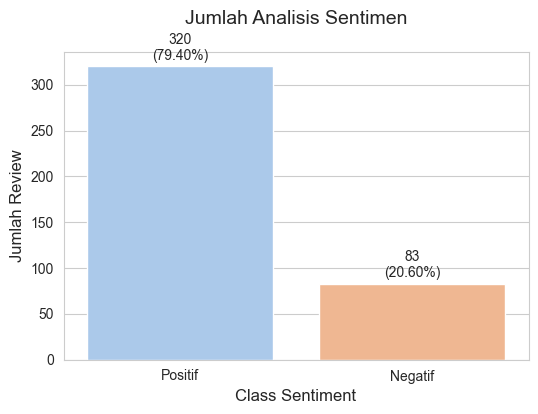

In [33]:
LABEL_TEXT_COL = "label_text"  # pastikan ini konsisten dengan kode sebelumnya

sentiment_count = df_lab[LABEL_TEXT_COL].value_counts()

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    x=sentiment_count.index,
    y=sentiment_count.values,
    palette="pastel",
    ax=ax
)

plt.title("Jumlah Analisis Sentimen", fontsize=14, pad=20)
plt.xlabel("Class Sentiment", fontsize=12)
plt.ylabel("Jumlah Review", fontsize=12)

total = len(df_lab)
for i, count in enumerate(sentiment_count.values):
    percentage = f"{100 * count / total:.2f}%"
    ax.text(
        i,
        count + (0.01 * total),  # supaya label tidak nabrak bar
        f"{count}\n({percentage})",
        ha="center",
        va="bottom"
    )

plt.show()

## 5) Split Data (80/20) (Bobot 25%)

Jumlah data latih: 322
Jumlah data uji: 81


,text,label_num
1141,yg komen baik baik pns pegawai bumn yg kerja s...,1
1206,mantap,1
548,percaya gak percaya allah swt maha tahu laku j...,1
2570,coba kalian pikir bijak bijak otak kalian muda...,0
1460,mantap pak prabowo priode jd presiden sehat pn...,1


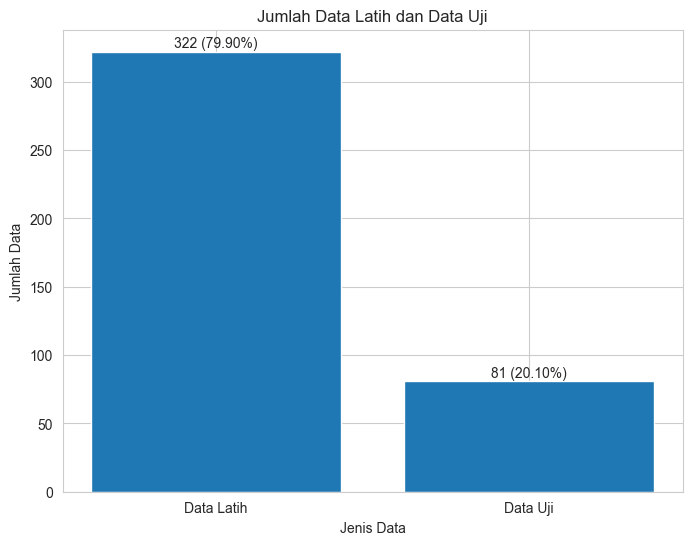

In [34]:
X_train, X_test, y_train_num, y_test_num = train_test_split(
    df_lab[TEXT_COL],
    df_lab["label_num"],      # numeric 0/1 sesuai instruksi TA
    test_size=0.2,
    random_state=42,
    stratify=df_lab["label_num"]
)

train_data = pd.DataFrame({"text": X_train, "label_num": y_train_num})
test_data  = pd.DataFrame({"text": X_test,  "label_num": y_test_num})

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))
display(train_data.head())

# Plot jumlah data latih dan data uji
train_size = len(X_train)
test_size = len(X_test)

plt.figure(figsize=(8, 6))
bars = plt.bar(["Data Latih", "Data Uji"], [train_size, test_size])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.7,
        f"{height} ({height / (train_size + test_size) * 100:.2f}%)",
        ha="center", va="bottom"
    )

plt.title("Jumlah Data Latih dan Data Uji")
plt.xlabel("Jenis Data")
plt.ylabel("Jumlah Data")
plt.show()

## 6) Feature Extraction: TF-IDF (Bobot 20%)
**Untuk laporan:** TF-IDF menurunkan bobot kata yang terlalu umum (sering muncul di banyak dokumen), sehingga fitur lebih informatif dibanding CountVectorizer yang hanya menghitung frekuensi kata.

In [35]:
X_train = X_train.fillna("")
X_test  = X_test.fillna("")

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print("Ukuran matriks TF-IDF (train):", X_train_vec.shape)
print("Contoh kecil matriks TF-IDF (5 baris pertama, 10 fitur pertama):")
print(X_train_vec[:5, :10].toarray())


Ukuran matriks TF-IDF (train): (322, 1123)
Contoh kecil matriks TF-IDF (5 baris pertama, 10 fitur pertama):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 7) Training & Evaluasi SVM (Linear vs RBF) (Bobot 25%)
Training & evaluasi **disatukan** dalam satu fungsi.

**Wajib:** Confusion Matrix + classification report + accuracy.


=== SVM Linear ===
Accuracy: 0.9506172839506173
Accuracy (%): 95.06%

Classification Report:
              precision    recall  f1-score   support

     Negatif       1.00      0.76      0.87        17
     Positif       0.94      1.00      0.97        64

    accuracy                           0.95        81
   macro avg       0.97      0.88      0.92        81
weighted avg       0.95      0.95      0.95        81



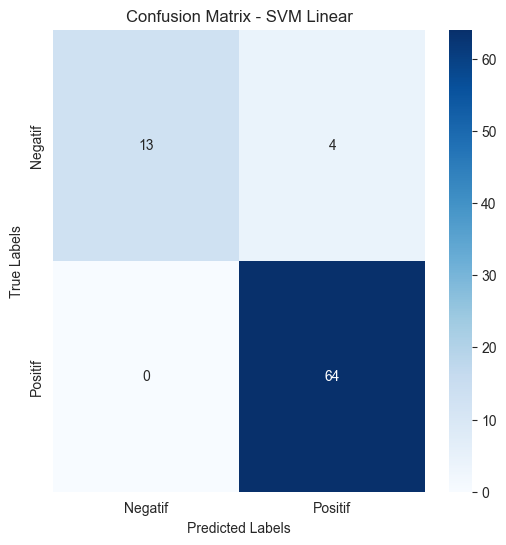


=== SVM RBF ===
Accuracy: 0.8518518518518519
Accuracy (%): 85.19%

Classification Report:
              precision    recall  f1-score   support

     Negatif       1.00      0.29      0.45        17
     Positif       0.84      1.00      0.91        64

    accuracy                           0.85        81
   macro avg       0.92      0.65      0.68        81
weighted avg       0.88      0.85      0.82        81



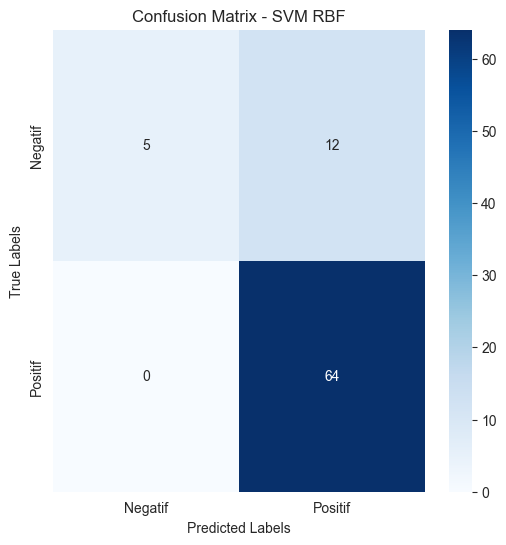

In [36]:
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        cbar=True,
        xticklabels=["Negatif", "Positif"],
        yticklabels=["Negatif", "Positif"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def train_and_evaluate(model, model_name, X_train_vec, y_train, X_test_vec, y_test):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print("Accuracy:", acc)
    print("Accuracy (%):", f"{acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Negatif","Positif"]))

    plot_confusion_matrix(model_name, y_test, y_pred)
    return y_pred

# SVM Linear
svm_linear = SVC(kernel="linear")
pred_linear = train_and_evaluate(
    svm_linear, "SVM Linear",
    X_train_vec, y_train_num,
    X_test_vec, y_test_num
)

# SVM RBF
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")
pred_rbf = train_and_evaluate(
    svm_rbf, "SVM RBF",
    X_train_vec, y_train_num,
    X_test_vec, y_test_num
)


## 8) Analisis Error (Bobot 25%)
Ambil contoh kalimat yang salah diprediksi dan analisis penyebabnya (sarkasme, kata ambigu, konteks).

In [37]:
# Error analysis untuk Linear
error_df_linear = pd.DataFrame({
    "text_raw": df_lab.loc[X_test.index, RAW_TEXT_COL].values,
    "text_clean": X_test.values,
    "y_true": y_test_num.values,
    "y_pred": pred_linear
})
wrong_linear = error_df_linear[error_df_linear["y_true"] != error_df_linear["y_pred"]].head(10)

print("=== Contoh 10 Salah Prediksi (Linear) ===")
display(wrong_linear)

# (Opsional) Error analysis untuk RBF
error_df_rbf = pd.DataFrame({
    "text_raw": df_lab.loc[X_test.index, RAW_TEXT_COL].values,
    "text_clean": X_test.values,
    "y_true": y_test_num.values,
    "y_pred": pred_rbf
})
wrong_rbf = error_df_rbf[error_df_rbf["y_true"] != error_df_rbf["y_pred"]].head(10)

print("=== Contoh 10 Salah Prediksi (RBF) ===")
display(wrong_rbf)


=== Contoh 10 Salah Prediksi (Linear) ===


,text_raw,text_clean,y_true,y_pred
11,bohong dan percuma,bohong percuma,0,1
46,kalian pcy....sy terlanjur kecewa,kalian pcy sy lanjur kecewa,0,1
51,Hanya rakyat konoha yang bisa dibohongi,rakyat konoha bohong,0,1
59,"1 lagi, menteri yg gak becus, yg gak bisa kerj...",menteri yg gak becus yg gak kerja bodoh pecat ...,0,1


=== Contoh 10 Salah Prediksi (RBF) ===


,text_raw,text_clean,y_true,y_pred
6,"yang benci BPK Prabowo,sedang merangkai kata"" ...",benci bpk prabowo sedang rangkai kata picik,0,1
8,pesan kepada pak Prabowo tolong di tindak lanj...,pesan pak prabowo tindak lanjut jalan lintas a...,0,1
9,kita jaga presiden kita dari para pembenci.......,jaga presiden benci rakyat indonesia lebih makmur,0,1
11,bohong dan percuma,bohong percuma,0,1
15,"kata gua mah mending ganti rakyat si, soalnya ...",kata gua mah mending ganti rakyat si soal peri...,0,1
46,kalian pcy....sy terlanjur kecewa,kalian pcy sy lanjur kecewa,0,1
47,"pembodohan dan pembohongan rakyat,",bodoh bohong rakyat,0,1
48,dan penjahat nya tidak ditangkap...apa artinya...,jahat nya tangkap apa arti cuma denda gitu doang,0,1
51,Hanya rakyat konoha yang bisa dibohongi,rakyat konoha bohong,0,1
59,"1 lagi, menteri yg gak becus, yg gak bisa kerj...",menteri yg gak becus yg gak kerja bodoh pecat ...,0,1


## 9) WordCloud (Wajib) (Bobot 25%)
Buat WordCloud untuk sentimen Positif dan Negatif.

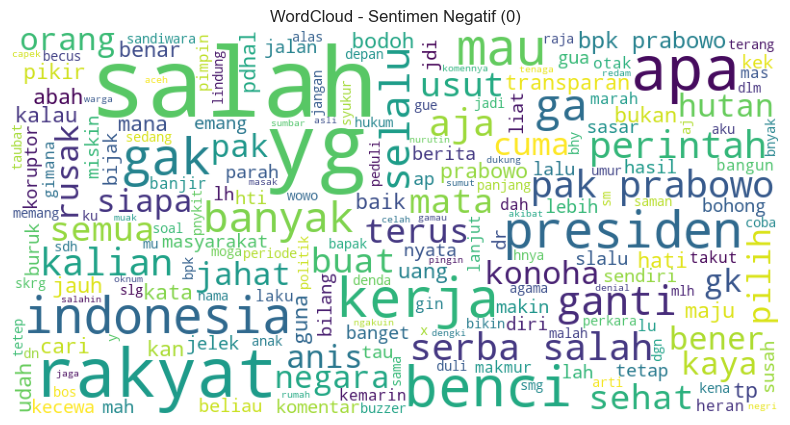

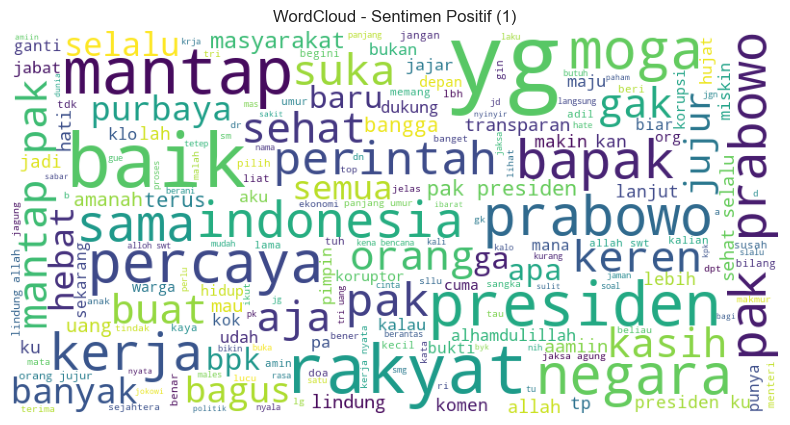

In [38]:
sentimen_negatif = df_lab[df_lab["label_num"] == 0][TEXT_COL].astype(str).str.cat(sep=" ")
sentimen_positif = df_lab[df_lab["label_num"] == 1][TEXT_COL].astype(str).str.cat(sep=" ")

def create_wordcloud(text, title):
    extra_stopwords = set(["https", "co", "rt", "amp", "nya", "ya", "sih"])
    extra_stopwords.update(["tiktok", "fyp", "viral"])

    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        max_font_size=100,
        random_state=42,
        stopwords=extra_stopwords
    ).generate(text)

    img = wc.to_image()
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

create_wordcloud(sentimen_negatif, "WordCloud - Sentimen Negatif (0)")
create_wordcloud(sentimen_positif, "WordCloud - Sentimen Positif (1)")


## 10) Hyperparameter Tuning Sederhana (Bobot 25%)
Tuning minimal `C` (Linear) dan `C` + `gamma` (RBF).

In [39]:
print("=== Tuning Linear (C) ===")
for C in [0.1, 1, 5, 10]:
    model = SVC(kernel="linear", C=C)
    model.fit(X_train_vec, y_train_num)
    pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test_num, pred)
    print(f"[Linear] C={C:<4} | Acc={acc:.4f}")

print("\n=== Tuning RBF (C & gamma) ===")
for C in [0.5, 1, 5]:
    for gamma in ["scale", 0.1, 0.01]:
        model = SVC(kernel="rbf", C=C, gamma=gamma)
        model.fit(X_train_vec, y_train_num)
        pred = model.predict(X_test_vec)
        acc = accuracy_score(y_test_num, pred)
        print(f"[RBF] C={C:<4} gamma={str(gamma):<6} | Acc={acc:.4f}")


=== Tuning Linear (C) ===
[Linear] C=0.1  | Acc=0.7901
[Linear] C=1    | Acc=0.9506
[Linear] C=5    | Acc=0.9630
[Linear] C=10   | Acc=0.9630

=== Tuning RBF (C & gamma) ===
[RBF] C=0.5  gamma=scale  | Acc=0.7901
[RBF] C=0.5  gamma=0.1    | Acc=0.7901
[RBF] C=0.5  gamma=0.01   | Acc=0.7901
[RBF] C=1    gamma=scale  | Acc=0.8519
[RBF] C=1    gamma=0.1    | Acc=0.7901
[RBF] C=1    gamma=0.01   | Acc=0.7901
[RBF] C=5    gamma=scale  | Acc=0.9136
[RBF] C=5    gamma=0.1    | Acc=0.9506
[RBF] C=5    gamma=0.01   | Acc=0.7901
